# This notebook is used to conduct experiments on neural network graph extraction.
## Procedure
1. Write a script which extracts information of the graph from a neural network model using flexible transform. It should be configurable which network types should be transformed in a low level manner and how often it is executed. 
2. Get the CSV data of a module e.g. AlexNet, ResNet or GoogleNet
3. Use pandas to load the csv data as dataframe
4. Use seaborn or plotly to visualize the data with boxplots

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleResNetLikeModel(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleResNetLikeModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(128)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x




In [ ]:
from matplotlib import pyplot as plt
import networkx as nx

def plot_graph(graph, title):
    labels = nx.get_node_attributes(graph, 'name')
    fig, ax = plt.subplots(figsize=(10, 10))
    nx.draw(graph, labels=labels, with_labels=True, node_size=700, node_color='lightblue', font_size=8,
            ax=ax)
    plt.title(title)
    plt.show()

# Test Stage for potential models

In [ ]:
from deepstruct.traverse_strategies import FXTraversal
from deepstruct.flexible_transform import GraphTransform
import torch
import torchvision

model = SimpleResNetLikeModel()
input_tensor = torch.rand(1, 3, 224, 224)
graph_transformer = GraphTransform(input_tensor, traversal_strategy=FXTraversal())
graph_transformer.transform(model)
graph = graph_transformer.get_graph()
print(graph)
plot_graph(graph, "Transformation")

In [ ]:
from deepstruct.node_map_strategies import LowLevelNodeMap
from deepstruct.traverse_strategies import FXTraversal
from deepstruct.flexible_transform import GraphTransform
import torch

model = SimpleResNetLikeModel()
input_tensor = torch.rand(1, 3, 224, 224)
graph_transformer = GraphTransform(input_tensor, traversal_strategy=FXTraversal(), node_map_strategy=LowLevelNodeMap())
graph_transformer.transform(model)
graph = graph_transformer.get_graph()
print(graph)
# plot_graph(graph, "Transformation")

In [ ]:
from deepstruct.model_graph_stats import get_model_graph_stats
import torch
import torchvision

graphs = get_model_graph_stats(torchvision.models.alexnet(True), torch.rand(1, 3, 224, 224), 100, 'AlexNet', 'AlexNet_High_Level')

In [ ]:
import torch
import torchvision
from deepstruct.node_map_strategies import Linear2LayerMapper, Conv2LayerMapper
from deepstruct.model_graph_stats import get_model_graph_stats

graphs = get_model_graph_stats(torchvision.models.resnet18(True), torch.rand(1, 3, 224, 224), 11, 'ResNet18', 'resnet18_low_level_linear', low_level_module_maps={torch.nn.Linear: Linear2LayerMapper(-1)})
print(graphs[0])
graphs = get_model_graph_stats(torchvision.models.resnet18(True), torch.rand(1, 3, 224, 224), 11, 'ResNet18', 'resnet18_low_level_conv', low_level_module_maps={torch.nn.Conv2d: Conv2LayerMapper(-1)})
print(graphs[0])

In [ ]:
import torch
import torchvision
from deepstruct.node_map_strategies import Linear2LayerMapper
from deepstruct.model_graph_stats import get_model_graph_stats

model = SimpleResNetLikeModel()
graphs = get_model_graph_stats(torchvision.models.mobilenet_v2(True), torch.rand(1, 3, 224, 224), 1, 'model', 'test_low_level_linear', low_level_module_maps={torch.nn.Linear: Linear2LayerMapper(-1)})
print(graphs[0])

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('graph_stats/AlexNet_High_Level.csv')
sns.boxplot(x='Model', y='Elapsed Time', data=df) # informationen zu samples hinzufügen 
plt.show() # skallierung der achsen (y-lim) muss vergleichbar sein

In [ ]:
class SimpleResNet(nn.Module):
    def __init__(self, in_channels, out_channels, num_classes):
        super(SimpleResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(out_channels, num_classes)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out


In [ ]:
import torch
from deepstruct.node_map_strategies import Linear2LayerMapper, Conv2LayerMapper
from deepstruct.model_graph_stats import get_model_graph_stats

batch_size = 4
channels = 3
height = 32
width = 32
input_tensor = torch.randn(batch_size, channels, height, width)
model = SimpleResNet(in_channels=3, out_channels=16, num_classes=10)

graphs = get_model_graph_stats(model, input_tensor, 11, 'SimpleResNet', 'SimpleResNet_low_level', 
                               low_level_module_maps={torch.nn.Linear: Linear2LayerMapper(-1),
                                                      torch.nn.Conv2d: Conv2LayerMapper(-1)})
print(graphs[0])

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('graph_stats/SimpleResNet_low_level.csv')
sns.boxplot(x='Model', y='Elapsed Time', data=df)
plt.show()

In [ ]:
import torch
from deepstruct.model_graph_stats import get_model_graph_stats


batch_size = 4
channels = 3
height = 32
width = 32
input_tensor = torch.randn(batch_size, channels, height, width)
model = SimpleResNet(in_channels=3, out_channels=16, num_classes=10)

graphs = get_model_graph_stats(model, input_tensor, 11, 'SimpleResNet', 'SimpleResNet_high_level')
print(graphs[0])

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('graph_stats/SimpleResNet_high_level.csv')
sns.boxplot(x='Model', y='Elapsed Time in sec', data=df)
plt.show()

# First Experiment

In [1]:
import torch.nn as nn

class FC_1000(nn.Module):
    
    def __init__(self):
        super(FC_1000, self).__init__()
        self.fc = nn.Linear(1000, 1000)
    
    def forward(self, x):
        return self.fc(x)
    
class FC_2000(nn.Module):
    
    def __init__(self):
        super(FC_2000, self).__init__()
        self.fc = nn.Linear(2000, 2000)
    
    def forward(self, x):
        return self.fc(x)
    
class Simple_Conv(nn.Module):

    def __init__(self):
        super(Simple_Conv, self).__init__()
        self.conv = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=5, stride=1, padding=1)
        
    def forward(self, x):
        return self.conv(x)
    

In [2]:
import torch
from deepstruct.model_graph_stats import get_model_graph_stats
from deepstruct.node_map_strategies import Linear2LayerMapper, Conv2LayerMapper

fc_1000 = FC_1000()
fc_2000 = FC_2000()
simple_conv = Simple_Conv()

fc_1000_input = torch.randn(1, 1000) # Batch size of 1
fc_2000_input = torch.randn(1, 2000) # Batch size of 1

conv_input = torch.randn(1, 3, 64, 64) 
conv_input2 = torch.randn(1, 3, 84, 84)


In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def effective_conv_operations(input_height, input_width, in_channel, output_channel, kernel_size, stride=1, padding=0):
    output_height = (input_height - kernel_size + 2 * padding) // stride + 1
    output_width = (input_width - kernel_size + 2 * padding) // stride + 1
    operations_per_output_element = kernel_size * kernel_size * in_channel
    total_conv_operations = operations_per_output_element * output_height * output_width * output_channel
    return total_conv_operations

print('fc_1000: ', count_parameters(fc_1000))
print('fc_2000: ', count_parameters(fc_2000))
print('simple_conv: ', count_parameters(simple_conv))
print('simple_conv ops: ', effective_conv_operations(64, 64, 3, 4, 5))
print('simple_conv ops 2: ', effective_conv_operations(84, 84, 3, 4, 5))

input_neurons_count = {'FC_1000': fc_1000_input.numel(), 'FC_2000': fc_2000_input.numel(),
                       'simple conv': conv_input.numel(), 'simple conv 2': conv_input2.numel()}

fc_1000:  1001000
fc_2000:  4002000
simple_conv:  304
simple_conv ops:  1080000
simple_conv ops 2:  1920000


In [6]:
get_model_graph_stats(simple_conv, conv_input, 11, 'simple conv', 'simple_conv_low_level', 
                      low_level_module_maps={torch.nn.Linear: Linear2LayerMapper(-1),
                                             torch.nn.Conv2d: Conv2LayerMapper(-1)})

get_model_graph_stats(simple_conv, conv_input2, 11, 'simple conv 2', 'simple_conv_2_low_level', 
                      low_level_module_maps={torch.nn.Linear: Linear2LayerMapper(-1),
                                             torch.nn.Conv2d: Conv2LayerMapper(-1)})

get_model_graph_stats(fc_1000, fc_1000_input, 11, 'FC_1000', 'FC_1000_low_level', 
                      low_level_module_maps={torch.nn.Linear: Linear2LayerMapper(-1),
                                             torch.nn.Conv2d: Conv2LayerMapper(-1)})

get_model_graph_stats(fc_2000, fc_2000_input, 11, 'FC_2000', 'FC_2000_low_level', 
                      low_level_module_maps={torch.nn.Linear: Linear2LayerMapper(-1),
                                             torch.nn.Conv2d: Conv2LayerMapper(-1)})

Tracing Nodes: 100%|██████████| 3/3 [00:15<00:00,  5.13s/it]


## Correlation analysis with multiple Boxplots in one Chart
### X = model names
### Y = elapsed time in seconds

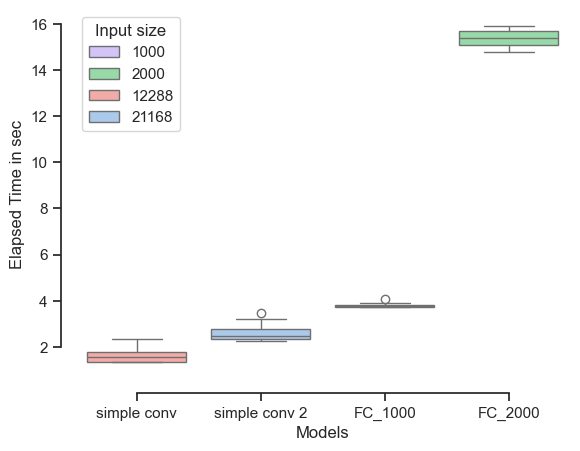

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

folder = "graph_stats/"
file_names = ["simple_conv_low_level.csv", "simple_conv_2_low_level.csv", "FC_1000_low_level.csv", "FC_2000_low_level.csv"]
dataframes = []
for file in file_names:
    df = pd.read_csv(folder + file)
    model_name = df.loc[1, 'Model']
    df['Input size'] = input_neurons_count[model_name]
    dataframes.append(df)

combined_df = pd.concat(dataframes)
sns.set_theme(style='ticks', palette='pastel')
sns.boxplot(x='Model', y='Elapsed Time', data=combined_df, hue='Input size', palette=['m', 'g', 'r', 'b'])
sns.despine(offset=10, trim=True)
plt.legend = 'Input tensor elements'
plt.xlabel('Models')
plt.ylabel('Elapsed Time in sec')
plt.show()


# Second Experiment

In [60]:
from deepstruct.traverse_strategies import FXTraversal
from deepstruct.flexible_transform import GraphTransform
import torch
import torchvision

model = torchvision.models.resnet152(True) # Reset152, GoogleNet und AlexNet
input_tensor = torch.rand(1, 3, 224, 224)
graph_transformer = GraphTransform(input_tensor, traversal_strategy=FXTraversal())
graph_transformer.transform(model)
graph = graph_transformer.get_graph()
print(graph)

Tracing Nodes: 100%|██████████| 517/517 [00:00<00:00, 33226.41it/s]

LayeredFXGraph with 517 nodes and 566 edges


In [62]:
# FC 1000, simple conv high level 
input_tensor = torch.rand(1, 3, 224, 224)
get_model_graph_stats(torchvision.models.resnet152(True), input_tensor, 11, 'ResNet_152', 'resnet_152_high_level')

get_model_graph_stats(torchvision.models.googlenet(True), input_tensor, 11, 'GoogleNet', 'googlenet_high_level')     

get_model_graph_stats(torchvision.models.alexnet(True), input_tensor, 11, 'AlexNet', 'alexnet_high_level')

Tracing Nodes: 100%|██████████| 24/24 [00:00<?, ?it/s]


In [64]:
get_model_graph_stats(simple_conv, conv_input, 11, 'simple conv', 'simple_conv_high_level')

get_model_graph_stats(fc_1000, fc_1000_input, 11, 'FC_1000', 'FC_1000_high_level')

Tracing Nodes: 100%|██████████| 3/3 [00:00<?, ?it/s]


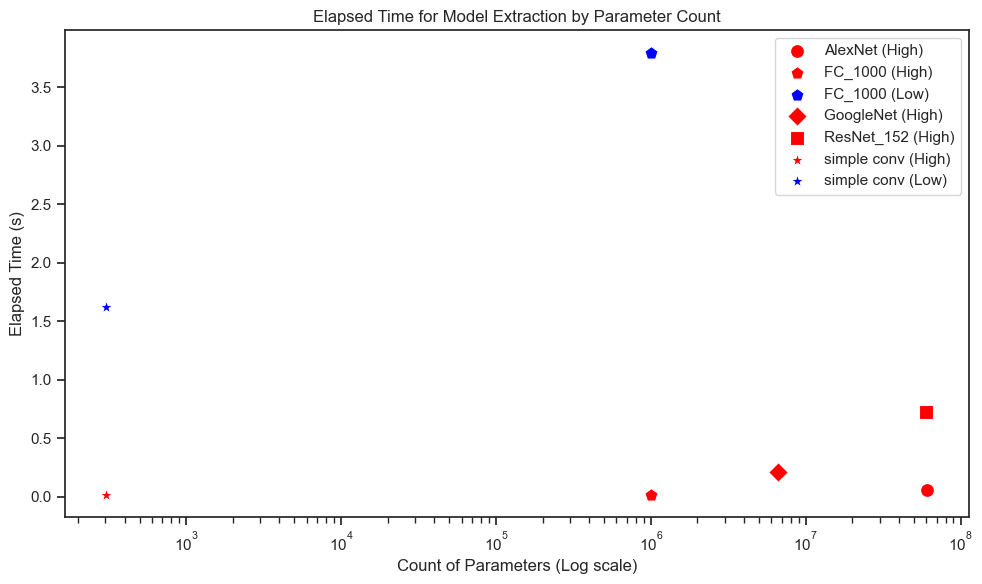

In [87]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

older = "graph_stats/"
file_names = ["simple_conv_low_level.csv", "simple_conv_high_level.csv", "FC_1000_high_level.csv",
              "FC_1000_low_level.csv", "alexnet_high_level.csv", "googlenet_high_level.csv", "resnet_152_high_level.csv"]
models = [simple_conv, simple_conv, fc_1000, fc_1000,
          torchvision.models.alexnet(True), torchvision.models.googlenet(True),
          torchvision.models.resnet152(True)]
final_df = pd.DataFrame(columns=['ModelName', 'ElapsedTime', 'CountOfParameters', 'ExtractionLevel'])

for file, model in zip(file_names, models):
    df = pd.read_csv(folder + file)
    data = [df['Model'][0], df['Elapsed Time'].mean(), count_parameters(model), 'High' if 'high' in file else 'Low']
    final_df.loc[len(final_df.index)] = data

markers = {'AlexNet': 'o', 'ResNet_152': 's', 'GoogleNet': 'D', 'simple conv': '*', 'FC_1000': 'p'} 
palette = {'Low': 'blue', 'High': 'red'} 

plt.figure(figsize=(10, 6))

for (modelName, extractionLevel), group_data in final_df.groupby(['ModelName', 'ExtractionLevel']):
    sns.scatterplot(x='CountOfParameters', y='ElapsedTime', data=group_data,
                    marker=markers[modelName], color=palette[extractionLevel], label=f'{modelName} ({extractionLevel})', s=100)

plt.title('Elapsed Time for Model Extraction by Parameter Count')
plt.xscale('log')
plt.xlabel('Count of Parameters (Log scale)')
plt.ylabel('Elapsed Time (s)')
# plt.legend(title='Model and Extraction Level', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()
